# <font color = "blue">Big Picture</font>

Goal: Analyze the NDMI (Normalized Difference Moisture Index) and deforestation of a region in Portugal. Use NDMI as a measure of soil moisture, and analyze if soil moisture changes as a result of deforestation 

Status: We have defined a study region, imported Landsat data, calculated NDMI, and done a little preliminary analysis

**Note**: The maps do not always show up in the file transfer. If you want to see the maps, please go to the following link: https://drive.google.com/file/d/1JquskqfqdTTJYZUW-l0lzbxdTl0yMkc0/view?usp=sharing . Then, **DOWNLOAD** the file (click the three dots in the upper right corner) and open the link using your file browser

## <font color = "purple">Import Modules</font>

In [ ]:
# Bring in ee module
! pip install ee
! pip install earthengine-api

import ee
ee.Authenticate()
ee.Initialize()

Enter verification code:  4/1AY0e-g7HN48ohJcfvo_Ow9puteRKLVrSHdgO0r5T5npxtWTCLVB6mcT_j4c



Successfully saved authorization token.


In [ ]:
# import geemap, folium, geopandas
# ! pip install geemap
import geemap.eefolium as geemap

import folium
import geopandas as gpd

## <font color = "purple">Visualize Study Regions</font>

In [ ]:
# open data
! unzip GFW_Study_sites.zip

Archive:  GFW_Study_sites.zip
   creating: GFW_Study_sites/
 extracting: GFW_Study_sites/forest_study_site.cpg  
  inflating: GFW_Study_sites/forest_study_site.dbf  
  inflating: GFW_Study_sites/forest_study_site.geojson  
  inflating: GFW_Study_sites/forest_study_site.prj  
  inflating: GFW_Study_sites/forest_study_site.sbn  
  inflating: GFW_Study_sites/forest_study_site.sbx  
  inflating: GFW_Study_sites/forest_study_site.shp  
  inflating: GFW_Study_sites/forest_study_site.shp.xml  
  inflating: GFW_Study_sites/forest_study_site.shx  
 extracting: GFW_Study_sites/non-forest_site.cpg  
  inflating: GFW_Study_sites/non-forest_site.dbf  
  inflating: GFW_Study_sites/non-forest_site.prj  
  inflating: GFW_Study_sites/non-forest_site.sbn  
  inflating: GFW_Study_sites/non-forest_site.sbx  
  inflating: GFW_Study_sites/non-forest_site.shp  
  inflating: GFW_Study_sites/non-forest_site.shp.xml  
  inflating: GFW_Study_sites/non-forest_site.shx  
  inflating: GFW_Study_sites/non_forest_sit

#### Map the study region 
(hover over map for region labels)

In [ ]:
# Set basemap to Portugal area
m = folium.Map(location = [37.1624, -8.8166], tiles = 'Stamen Terrain', zoom_start = 8)

# Add title
loc = 'Map of Study Regions'
title_html = '''
             <h3 align="center" style="font-size:20px"><b>{}</b></h3>
             '''.format(loc)   

m.get_root().html.add_child(folium.Element(title_html))


# Add study sites
forest_site = gpd.read_file('GFW_Study_sites/forest_study_site.shp')
folium.GeoJson(data = forest_site['geometry'],tooltip='Forested Site').add_to(m)

nonFor_site = gpd.read_file('GFW_Study_sites/non-forest_site.shp')
folium.GeoJson(data = nonFor_site['geometry'],tooltip='Non-Forested Site').add_to(m)

# Display map with layers
m

## <font color = "purple">Landsat Data Analysis</font>

#### Bring in data from Earth Engine

In [ ]:
# define study regions 
# Fpoly = forested region, NFpoly = non-forested region, poly = union of the two regions
Fpoly = ee.Geometry.Polygon([[-8.983251455552148, 37.03202729749413], [-8.938407404753626, 37.01564295573093], [-8.839598479006515, 37.07448876137959], [-8.786438207989903, 37.06701944575602], [-8.608297116446243, 37.13509966926231], [-8.366835774784887, 37.19688714728755], [-7.918645907543649, 37.360445409575846], [-8.52761188660918, 37.78538778672386], [-8.753710720880177, 37.550841748906834], [-8.898883834634427, 37.16782032004561], [-8.983251455552148, 37.03202729749413]])
NFpoly = ee.Geometry.Polygon([[-8.52761188660918, 37.78538778672386], [-7.918645907543649, 37.360445409575846], [-7.236981839919429, 37.94014314579341], [-8.043023887548204, 38.37332029956296], [-8.52761188660918, 37.78538778672386]])
poly = Fpoly.union(NFpoly)

# define dates of imagery 
start = ee.Date('2014-01-01')
finish = ee.Date('2020-12-01')

# bring in imagery 
filteredCollection = ee.ImageCollection('LANDSAT/LC08/C01/T1_SR') \
    .filterBounds(poly) \
    .filterDate(start, finish) \
    .sort('CLOUD_COVER',True) # filteredCollection is an image collection of Landsat 8 data within the study region from 2014-2020

# sources: 
# - https://developers.google.com/earth-engine/guides/ic_creating
# - https://github.com/giswqs/earthengine-py-notebooks/blob/master/ImageCollection/clipped_composite.ipynb

#### Calculate NDMI for every image

In [ ]:
def compNDMI(image):
    NDMI = image.normalizedDifference(['B5','B6']).rename('NDMI')
    return image.addBands(NDMI)

withNDMI = filteredCollection.map(compNDMI) # withNDMI is an image collection of pixel values for NDMI for every Landsat 8 image within the study region

# sources: 
# - https://github.com/giswqs/earthengine-py-notebooks/blob/master/GetStarted/04_band_math.ipynb
# - https://developers.google.com/earth-engine/tutorials/community/intro-to-python-api-guiattard (GOOD LINK)
# - https://developers.google.com/earth-engine/tutorials/tutorial_api_06

#### Calculate a monthly pixel-by-pixel mean for NDMI

In [ ]:
months = range(1,13)
years = range(2014,2021) 

# define a function to calculate a pixelwise band average
def monthlyMean(imgCollection):
    myList = ee.List([])
    for y in years: 
        for m in months: 
            w = imgCollection.filter(ee.Filter.calendarRange(y, y, 'year')).filter(ee.Filter.calendarRange(m, m, 'month')).reduce(ee.Reducer.mean())
            myList = myList.add(w.set('year',y).set('month',m).set('system:time_start',ee.Date.fromYMD(y,m,1)))
    return ee.ImageCollection.fromImages(myList)

# run the function
ndmiMean = monthlyMean(withNDMI) # image collection of monthly band averages for the landsat imagery

# sources: 
# - https://gis.stackexchange.com/questions/301165/how-to-get-monthly-averages-from-earth-engine-in-the-python-api

#### Print out properties of ndmiMean (debugging step)

In [ ]:
myImg = ndmiMean.first()
print('Collection Type:',type(ndmiMean),'\n')
print('Band Names:',ndmiMean.first().bandNames().getInfo(),'\n')
print('Size:',ndmiMean.size().getInfo())
print('Image type:',type(ndmiMean.first()),'\n')
print('Band types:',myImg.bandTypes().getInfo(),'\n')
print('Properties:',myImg.propertyNames().getInfo())
print('Geometry:',myImg.geometry().centroid().getInfo())
print('Time stamp:',myImg.get('system:time_start').getInfo().get('value'))

Collection Type: <class 'ee.imagecollection.ImageCollection'> 

Band Names: ['B1_mean', 'B2_mean', 'B3_mean', 'B4_mean', 'B5_mean', 'B6_mean', 'B7_mean', 'B10_mean', 'B11_mean', 'sr_aerosol_mean', 'pixel_qa_mean', 'radsat_qa_mean', 'NDMI_mean'] 

Size: 84
Image type: <class 'ee.image.Image'> 

Band types: {'B10_mean': {'type': 'PixelType', 'precision': 'double', 'min': -32768, 'max': 32767}, 'B11_mean': {'type': 'PixelType', 'precision': 'double', 'min': -32768, 'max': 32767}, 'B1_mean': {'type': 'PixelType', 'precision': 'double', 'min': -32768, 'max': 32767}, 'B2_mean': {'type': 'PixelType', 'precision': 'double', 'min': -32768, 'max': 32767}, 'B3_mean': {'type': 'PixelType', 'precision': 'double', 'min': -32768, 'max': 32767}, 'B4_mean': {'type': 'PixelType', 'precision': 'double', 'min': -32768, 'max': 32767}, 'B5_mean': {'type': 'PixelType', 'precision': 'double', 'min': -32768, 'max': 32767}, 'B6_mean': {'type': 'PixelType', 'precision': 'double', 'min': -32768, 'max': 32767}, 'B

#### Clip data to study regions

In [ ]:
# clip to forested region
def clippingF(img): 
    return img.clip(Fpoly)

ndmiMeanFClipped = ndmiMean.map(clippingF)

# clip to nonforested region 
def clippingNF(img):
    return img.clip(NFpoly)

ndmiMeanNFClipped = ndmiMean.map(clippingNF)

#### Map 1 image from the dataset (debugging step)

In [ ]:
Map1 = geemap.Map(center=[40,-100], zoom=4)

diffImg = ndmiMeanFClipped.filterMetadata('month','equals',2)
Map1.centerObject(diffImg,9)
vizParamsndmi = {'bands':['NDMI_mean'],'min':-1,'max':1}
Map1.addLayer(diffImg,vizParamsndmi,'Test')

Map1

#### Calculate the average NDMI value for the forested and deforested regions

In [ ]:
# forested regional avg
def regionalAvgF(img):
    myDict = img.reduceRegion(ee.Reducer.median(),Fpoly,500)
    return ee.Feature(None,myDict)

FregionalNDMI = ndmiMeanFClipped.map(regionalAvg)

# non-forested regional avg
def regionalAvg(img):
    myDict = img.reduceRegion(ee.Reducer.median(),NFpoly,500)
    return ee.Feature(None,myDict)

NFregionalNDMI = ndmiMeanNFClipped.map(regionalAvg)

#### Get a list of dates from the regional average image collections

In [ ]:
datesF = ee.List(ndmiMeanFClipped \
    .aggregate_array('system:time_start')) \
    .map(lambda time_start: 
         ee.Date(time_start).format('Y-MM-dd')
    ) \
    .getInfo()

datesNF = ee.List(ndmiMeanNFClipped \
    .aggregate_array('system:time_start')) \
    .map(lambda time_start: 
         ee.Date(time_start).format('Y-MM-dd')
    ) \
    .getInfo()

# source: 
# - https://gis.stackexchange.com/questions/345598/mapping-simple-function-to-print-date-and-time-stamp-on-google-earth-engine-pyth/345614

## <font color = "purple">Preliminary Data Analysis</font>

In [ ]:
# import pandas
import pandas as pd

#### Make a pandas dataframe from the regional averaging data

In [ ]:
# Convert regional NDMI values to a list
FfinalNDMI = ee.List(FregionalNDMI \
    .aggregate_array('NDMI_mean')) \
    .getInfo()

NFfinalNDMI = ee.List(NFregionalNDMI \
    .aggregate_array('NDMI_mean')) \
    .getInfo()

# make a dataframe
df = pd.DataFrame([datesF,FfinalNDMI,datesNF,NFfinalNDMI])
df = df.T
df.columns = ['F Dates','F NDMI','NF Dates','NF NDMI']
df

# force column types
df['F NDMI'] = df['F NDMI'].astype('float64')
df['F Dates'] = df['F Dates'].astype('datetime64')
df['NF NDMI'] = df['NF NDMI'].astype('float64')
df['NF Dates'] = df['NF Dates'].astype('datetime64')

#### Plot time series

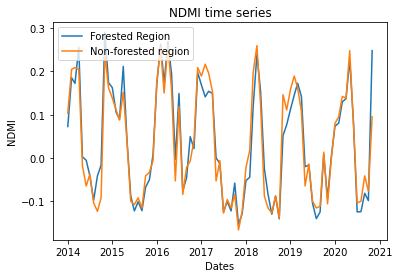

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax =plt.subplots()
ax = sns.lineplot(x = "F Dates",y="F NDMI",data=df)
ax = sns.lineplot(x = "NF Dates",y="NF NDMI",data=df)
ax.set_title('NDMI time series')
ax.set_xlabel('Dates')
ax.set_ylabel('NDMI')
ax.legend(['Forested Region','Non-forested region'],loc=2)